In [1]:
import argparse
import torch
import numpy as np
import wandb
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Unet1D, GaussianDiffusion1D
from unnormalized_densities import Toy_dataset
from torch.utils.data import DataLoader
from tqdm import trange
from probability_flow_ode import ProbabilityFlowODE


from net import MLP, UnclippedDiffusion

/home/sujin/anaconda3/envs/toy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

datanum = 50000
num_epochs = 1000
output_file = 'images/sampled_images.png'
model_save_path = 'models/trained_model.pth'
distribution = 'elliptic_paraboloid'



train_batch_size = 100
sample_batch_size = 100
num_inner_epochs = 1

In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model setup
model = MLP()

diffusion = UnclippedDiffusion(
    model=model,
    seq_length=2,
    timesteps=100,
    auto_normalize=False,
)

model = model.to(device)
diffusion = diffusion.to(device)

state_dict = torch.load(f"models/{distribution}/save_model.pt")
diffusion.load_state_dict(state_dict)


/tmp/ipykernel_1140075/4150609115.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"models/{distribution}/save_model.pt")


<All keys matched successfully>

In [8]:
shape = (int(datanum/10), diffusion.channels, diffusion.seq_length)
diffusion.sampling_timesteps = 100
latents= diffusion.ddim_sample(shape = shape, ddim_sampling_eta=0.0)  # Shape: (1000, 2)

In [13]:
latents= diffusion.ddim_sample(shape = shape, ddim_sampling_eta=0.0)  # Shape: (1000, 2)

sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 23.15it/s]


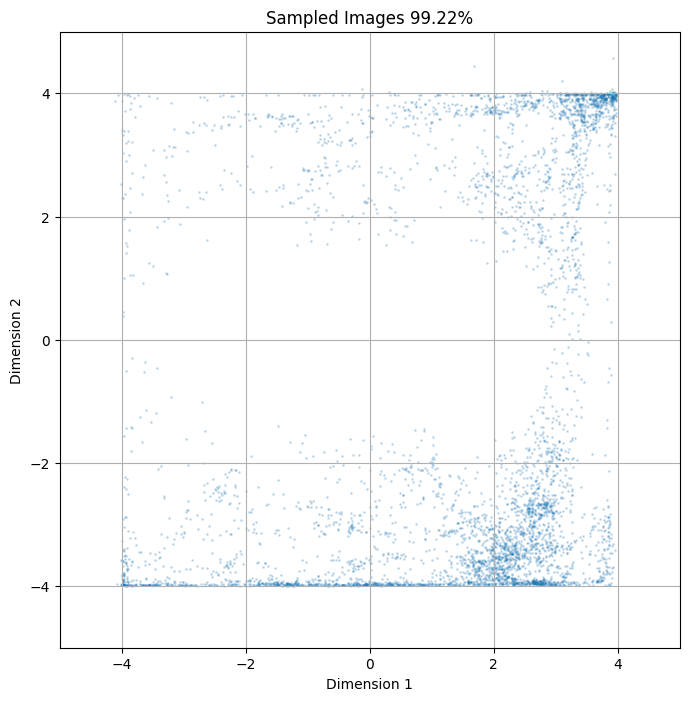

In [14]:

sampled_images = latents.squeeze(1).cpu().detach().numpy()  # Shape: (1000, 2)
within_bounds = np.all((sampled_images >= -5) & (sampled_images <= 5), axis=1)
proportion_within_bounds = np.mean(within_bounds)

plt.figure(figsize=(8, 8))
plt.scatter(sampled_images[:, 0], sampled_images[:, 1], alpha=0.2, s=1)
plt.title(f"Sampled Images {proportion_within_bounds * 100:.2f}%")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.grid(True)


plt.show()

In [10]:
latents[0].shape

torch.Size([5000, 1, 2])

In [11]:
logprobs[0].shape

torch.Size([5000])

In [12]:
len(logprobs)

99

In [15]:
# einops for switching dimensions
lat = torch.stack(logprobs, dim = 1)
print(lat.shape)

torch.Size([5000, 99])


In [5]:
densities = np.exp(gmm.score_samples(XY))
densities

array([3.25201407e-16, 6.29849660e-16, 1.19698530e-15, ...,
       5.52245584e-14, 3.02323875e-14, 1.64907970e-14])

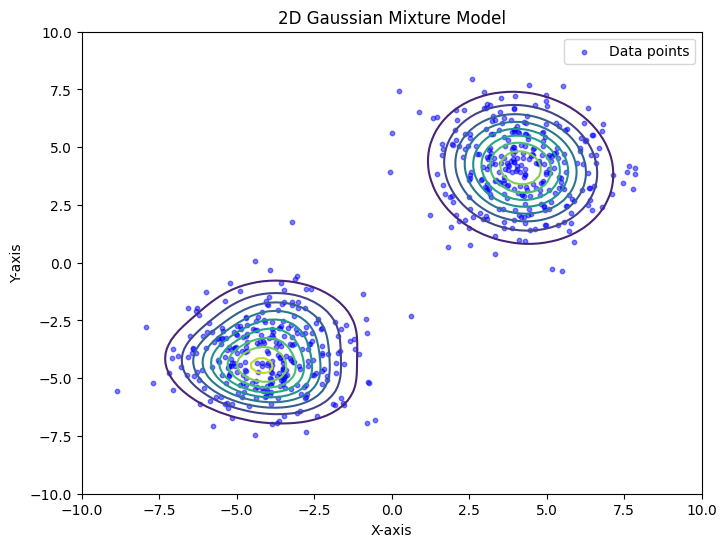

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 가우시안 혼합 모델 설정
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
np.random.seed(42)
data1 = np.random.randn(300, 2) * 1.5 - 4      # 원래 데이터 (평균 대략 (0,0))
data2 = np.random.randn(300, 2) * 1.5 + 4          # (4,4) 부근 데이터 (평균 대략 (4,4))

data = np.vstack([data1, data2])   
gmm.fit(data)

# 밀도 계산을 위한 grid 생성
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])

# 밀도 계산
densities = np.exp(gmm.score_samples(XY))
Z = densities.reshape(100, 100)

# 시각화
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=10, cmap='viridis')
plt.scatter(data[:, 0], data[:, 1], c='blue', s=10, alpha=0.5, label='Data points')
plt.title("2D Gaussian Mixture Model")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.show()

In [22]:
np.exp(gmm.score_samples(np.array([[4,4]])))

array([0.09144145])

In [25]:
np.exp(gmm.score_samples(np.array([[-4,4]])))

array([4.07860007e-09])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = MLP()

diffusion = UnclippedDiffusion(
    model=model,
    seq_length=2,
    timesteps=500,
    auto_normalize=False,
)

model = model.to(device)
diffusion = diffusion.to(device)
# Dataset and DataLoader
custom = Toy_dataset("elliptic_paraboloid", minimum=0, datanum=50000, device=device)
dataloader = DataLoader(custom, batch_size=1024, shuffle=True)

# Optimizer
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)

# Training loop
for epoch in trange(2):
    epoch_loss = 0
    batch_count = 0
    for batch in dataloader:
        training_data = batch[:, None, :]  # Extract the training data
        print(training_data.shape)

 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]

torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([1024, 1, 2])
torch.Size([848, 1, 2])


In [18]:
import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.linalg import cholesky, solve_triangular

class GMM:
    def __init__(self, means=None, covariances=None, weights=None, covariance_type='full', random_state=42, rewardfn_path="rewardfns/custom_2d_gmm.pkl"):
        self.covariance_type = covariance_type
        self.random_state = random_state
        
        if means is not None and covariances is not None and weights is not None:
            # 사용자가 직접 파라미터를 설정한 경우
            self.gmm = GaussianMixture(n_components=len(weights), covariance_type=self.covariance_type, random_state=self.random_state)
            self.gmm.weights_ = np.array(weights)
            self.gmm.means_ = np.array(means)
            self.gmm.covariances_ = np.array(covariances)
            self.gmm.precisions_cholesky_ = self._compute_precision_cholesky(self.gmm.covariances_, self.covariance_type)
            self.gmm.converged_ = True
        elif os.path.exists(rewardfn_path):
            # 저장된 GMM을 로드
            with open(rewardfn_path, "rb") as f:
                self.gmm = pickle.load(f)
        else:
            # 기본 데이터로 GMM을 피팅
            self.gmm = self._fit_default_gmm()
            with open(rewardfn_path, "wb") as f:
                pickle.dump(self.gmm, f)
        
        # 시각화를 위한 데이터 준비
        self._plot_gmm(rewardfn_path)
    
    def _compute_precision_cholesky(self, covariances, covariance_type):
        """
        covariances: array-like, shape (n_components, n_features, n_features) 또는 (n_features, n_features)
        """
        if covariance_type == 'full':
            precisions_cholesky = np.empty_like(covariances)
            for k, covariance in enumerate(covariances):
                try:
                    chol = cholesky(covariance, lower=True)
                except np.linalg.LinAlgError:
                    raise ValueError(f"Covariance matrix at index {k} is not positive definite.")
                precisions_cholesky[k] = solve_triangular(chol, np.eye(chol.shape[0]), lower=True)
        elif covariance_type == 'diag':
            precisions = 1. / covariances
            precisions_cholesky = np.sqrt(precisions)
        elif covariance_type == 'tied':
            try:
                chol = cholesky(covariances, lower=True)
            except np.linalg.LinAlgError:
                raise ValueError("Tied covariance matrix is not positive definite.")
            precisions_cholesky = solve_triangular(chol, np.eye(chol.shape[0]), lower=True)
        else:
            raise ValueError(f"Unsupported covariance type: {covariance_type}")
        
        return precisions_cholesky

    def _fit_default_gmm(self):
        gmm = GaussianMixture(n_components=2, covariance_type=self.covariance_type, random_state=self.random_state)
        np.random.seed(self.random_state)
        data1 = np.random.randn(300, 2) * 1.3 - 4      # 평균 대략 (-4,-4)
        data2 = np.random.randn(300, 2) * 1.3 + 4      # 평균 대략 (4,4)
        data = np.vstack([data1, data2])
        gmm.fit(data)
        return gmm

    def _plot_gmm(self, save_path):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        XY = np.column_stack([X.ravel(), Y.ravel()])
        
        densities = np.exp(self.gmm.score_samples(XY))
        Z = densities.reshape(100, 100)
        
        # 데이터 포인트 생성 (시각화를 위해)
        if hasattr(self.gmm, 'means_'):
            # 직접 설정한 경우 데이터 생성하지 않음
            data = []
            for mean, cov in zip(self.gmm.means_, self.gmm.covariances_):
                if self.covariance_type == 'full':
                    data.append(np.random.multivariate_normal(mean, cov, 300))
                elif self.covariance_type == 'diag':
                    cov_matrix = np.diag(cov)
                    data.append(np.random.multivariate_normal(mean, cov_matrix, 300))
                elif self.covariance_type == 'tied':
                    data.append(np.random.multivariate_normal(mean, cov, 300))
            data = np.vstack(data)
        else:
            data = np.random.randn(600, 2)  # 임의 데이터
        
        plt.figure(figsize=(8, 6))
        plt.contour(X, Y, Z, levels=10, cmap='viridis')
        plt.scatter(data[:, 0], data[:, 1], c='blue', s=10, alpha=0.5, label='Data points')
        plt.title("2D Gaussian Mixture Model")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.legend()
        
        plt.savefig(save_path.replace('.pkl', '.png'), dpi=300)
        plt.show()

    def __call__(self, x):
        """
        x: Tensor of shape (..., 2)
        Returns: Tensor of likelihoods with shape (...)
        """
        # 입력 텐서를 numpy 배열로 변환
        x_np = x.detach().cpu().squeeze().numpy()
        if x_np.ndim == 1:
            x_np = x_np.reshape(1, -1)
        
        # likelihood 계산 (exp(log_likelihood))
        log_likelihood = self.gmm.score_samples(x_np)
        return torch.exp(torch.tensor(log_likelihood, dtype=torch.float32, device=x.device))


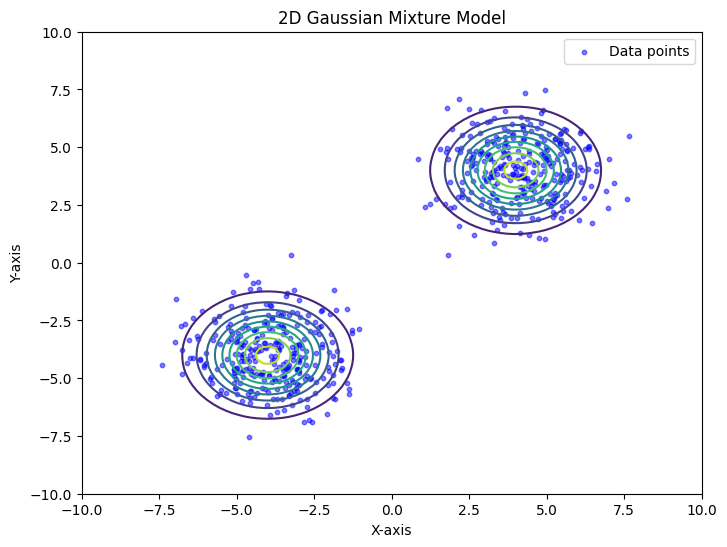

Sample [4.0, 4.0] has likelihood: 0.04708726331591606
Sample [0.0, 0.0] has likelihood: 7.28232089386438e-06
Sample [1.0, 1.0] has likelihood: 0.00022915343288332224
Sample [2.0, 2.0] has likelihood: 0.004415578208863735
Sample [3.0, 3.0] has likelihood: 0.02605700120329857


In [ ]:
import torch

# 직접 GMM 파라미터 설정
means = [[-4, -4], [4, 4]]
covariances = [
    [[1.69, 0], [0, 1.69]],  # 1.3^2 = 1.69
    [[1.69, 0], [0, 1.69]]
]
weights = [0.5, 0.5]

gmm = GMM(means=means, covariances=covariances, weights=weights, covariance_type='full', rewardfn_path="rewardfns/custom_2d_gmm.pkl")

# 샘플의 likelihood 계산
sample = torch.tensor([4.0, 4.0])  # (4,4) 위치의 샘플
likelihood = gmm(sample)
print(f"Sample {sample.tolist()} has likelihood: {likelihood.item()}")

# 다른 샘플 예시
sample2 = torch.tensor([0.0, 0.0])
likelihood2 = gmm(sample2)
print(f"Sample {sample2.tolist()} has likelihood: {likelihood2.item()}")

# 다수의 샘플에 대한 likelihood 계산
samples = torch.tensor([[1.0, 1.0], [2.0, 2.0], [3.0, 3.0]])
likelihoods = gmm(samples)
for s, l in zip(samples, likelihoods):
    print(f"Sample {s.tolist()} has likelihood: {l.item()}")

In [31]:
import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
class MultiCenterParaboloid:
    def __init__(
        self, 
        a=1.0, 
        b=1.0, 
        c=0.0, 
        sigma=1.0,
        centers=None,         # [(x0_1, y0_1), (x0_2, y0_2), ..., (x0_K, y0_K)]
        weights=None,         # [w1, w2, ..., wK], sum(weights)=1
        random_state=42,
        model_path="rewardfns/configs/multi_paraboloid.pkl",
        load_model=False
    ):
        """
        initialize a multi-center(k) paraboloid model. 

        f_k(x, y) = a*(x - x0_k)^2 + b*(y - y0_k)^2 + c

        Likelihood = sum_k [ w_k * exp( - f_k(x,y)^2 / (2 * sigma^2) ) ]

        Parameters:
        -----------
        a, b, c : float
            coefficients of the paraboloid.(all paraboloids share the same coefficients)
        sigma : float
            standard deviation of the Gaussian term.(all paraboloids share the same sigma)
        centers : list of tuple
            center of each paraboloid. ex: [(0,0), (2,2), ...].
            if None, initialize with a single center at (0,0).
        weights : list or np.ndarray
            weight of each paraboloid. sum(weights) must be 1.
            if None, initialize with uniform distribution.
        random_state : int
            seed for random number generator.
        model_path : str
            path to save the model parameters.
        load_model : bool
            if True, load the model parameters from the model_path, ignore other parameters.
        """
        self.a = a
        self.b = b
        self.c = c
        self.sigma = sigma
        self.random_state = random_state
        self.model_path = model_path


        if centers is None or len(centers) == 0:
            centers = [(0.0, 0.0)]
        self.centers = np.array(centers, dtype=np.float32)  # shape = (K, 2)


        K = len(self.centers)
        if weights is None:
            weights = np.ones(K) / K
        else:
            weights = np.array(weights, dtype=np.float32)
            if not np.isclose(np.sum(weights), 1.0):
                raise ValueError("sum of weights must be 1.")
        self.weights = weights

        if load_model:
            if os.path.exists(self.model_path):
                with open(self.model_path, "rb") as f:
                    params = pickle.load(f)
                    self.a = params['a']
                    self.b = params['b']
                    self.c = params['c']
                    self.sigma = params['sigma']
                    self.centers = params['centers']
                    self.weights = params['weights']
            else:
                raise FileNotFoundError(f"Model file not found at {self.model_path}")
        else:
            params = {
                'a': self.a,
                'b': self.b,
                'c': self.c,
                'sigma': self.sigma,
                'centers': self.centers,
                'weights': self.weights
            }
            os.makedirs(os.path.dirname(self.model_path), exist_ok=True)
            with open(self.model_path, "wb") as f:
                pickle.dump(params, f)

        self._plot_model()

    def _plot_model(self, xlim=(-8, 8), ylim=(-8, 8), num_grid=100):
        """
        plot the likelihood surface of the multi-center paraboloid model.
        """
        np.random.seed(self.random_state)

        x_vals = np.linspace(xlim[0], xlim[1], num_grid)
        y_vals = np.linspace(ylim[0], ylim[1], num_grid)
        X, Y = np.meshgrid(x_vals, y_vals)

        pdf_grid = np.zeros_like(X, dtype=np.float32)

        for i in range(num_grid):
            for j in range(num_grid):
                x_ij = X[i, j]
                y_ij = Y[i, j]
                pdf_val = 0.0
                for w_k, (cx, cy) in zip(self.weights, self.centers):
                    f_k = self.a * (x_ij - cx)**2 + self.b * (y_ij - cy)**2 + self.c
                    pdf_val += w_k * np.exp(- (f_k ** 2) / (2.0 * self.sigma ** 2))
                pdf_grid[i, j] = pdf_val

        plt.figure(figsize=(8, 6))
        contour = plt.contourf(X, Y, pdf_grid, levels=40, cmap='viridis')
        plt.colorbar(contour, label='Likelihood')

        plt.scatter(self.centers[:, 0], self.centers[:, 1], c='red', marker='x', s=100, label='Centers')

        plt.title("Multi-Center Paraboloid Likelihood")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.legend()
        plt.savefig(self.model_path.replace('.pkl', '.png'), dpi=300)
        plt.show()

    def __call__(self, x):
        """
        calculate likelihood for each sample in x
        Parameters:
        -----------
        x : torch.Tensor of shape (..., 2)

        Returns:
        --------
        torch.Tensor of shape (...):
            likelihood for each sample(weighted sum of K paraboloids)  
        """
        # x: (N, 2) or (2,) 
        x_np = x.detach().cpu().squeeze().numpy()

        if x_np.ndim == 1:
            x_np = x_np.reshape(1, -1)  # (1, 2)

        N = x_np.shape[0]
        K = len(self.centers)

        # 결과 배열 (N,)
        likelihoods = np.zeros(N, dtype=np.float32)

        for i in range(N):
            xi, yi = x_np[i]
            pdf_val = 0.0
            for w_k, (cx, cy) in zip(self.weights, self.centers):
                f_k = self.a * (xi - cx)**2 + self.b * (yi - cy)**2 + self.c
                pdf_val += w_k * np.exp(- (f_k ** 2) / (2.0 * self.sigma ** 2))
            likelihoods[i] = pdf_val

        return torch.tensor(likelihoods, dtype=torch.float32, device=x.device)


In [68]:

import torch

# 파라볼로이드 K=3개
centers = [(7, 7), (-7, 7), (7, -7), (-7, -7)]
weights = [0.25, 0.25, 0.25, 0.25]  # 가중치 합=1

a = 1.0
b = 1.0
c = 0.0

sigma = 1

lc = len(centers)


weight_type = "uniform"

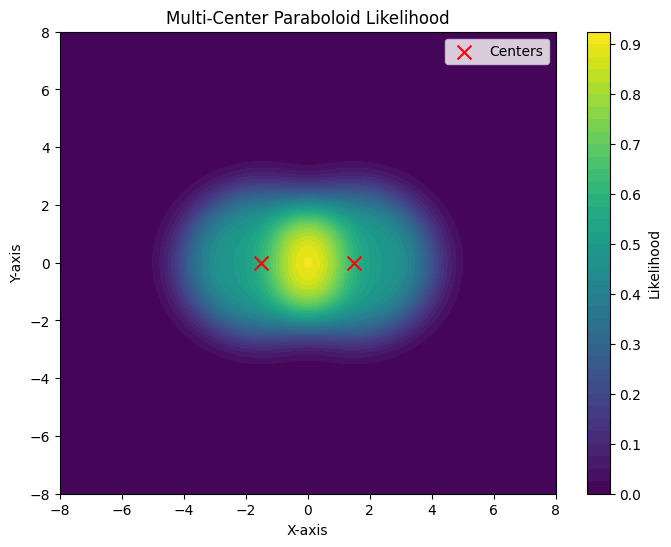

Likelihoods: tensor([0.9037, 0.3509, 0.4995, 0.6594, 0.0612])


In [69]:

# 모델 초기화
model = MultiCenterParaboloid(
    a=a,
    b=b,
    c=c,
    sigma=sigma,
    centers=centers,
    weights=weights,
    model_path=f"rewardfns/configs/multi_paraboloid_a{a}_b{b}_c{c}_sigma{sigma}_center{lc}_{centers[0][0]}{centers[0][1]}_{weight_type}.pkl"
)

# 임의의 입력 텐서
x_samples = torch.tensor([
    [0.0, 0.0],  # 첫 번째 중심
    [2.0, 2.0],  # 두 번째 중심
    [-2.0, 1.0], # 세 번째 중심
    [1.0, 1.0],  # 중간 지점
    [4.0, -2.0]  # 랜덤 지점
])

# likelihood 계산
likelihoods = model(x_samples)
print("Likelihoods:", likelihoods)

In [28]:
import numpy as np

def multivariate_gaussian_pdf(x, mean, cov):
    """
    다변량 정규분포의 pdf를 계산하는 함수.
    x:     (D,) shape의 1차원 numpy array (샘플)
    mean:  (D,) shape의 1차원 numpy array (평균)
    cov:   (D, D) shape의 2차원 numpy array (공분산 행렬)
    return: x가 mean, cov를 가지는 다변량 정규분포일 때의 pdf 값
    """
    D = len(mean)  # 데이터 차원
    # 행렬식(det)과 역행렬(inverse)을 구함
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    
    # 정규화 상수 (1 / sqrt((2π)^D * det(Sigma)))
    norm_factor = 1.0 / (np.sqrt((2 * np.pi)**D * cov_det))
    
    # 지수 부분 exp(-1/2 (x - mu)^T Sigma^-1 (x - mu))
    diff = x - mean
    exponent = -0.5 * np.dot(np.dot(diff.T, cov_inv), diff)
    
    return norm_factor * np.exp(exponent)

def gmm_pdf(x, weights, means, covariances):
    """
    GMM의 pdf 값을 반환하는 함수.
    x:             (D,) shape의 1차원 numpy array
    weights:       길이가 K인 list 혹은 np.array (각 컴포넌트의 mixing coefficient)
    means:         (K, D) shape의 numpy array (각 컴포넌트의 평균)
    covariances:   (K, D, D) shape의 numpy array (각 컴포넌트의 공분산 행렬)
    return: x에 대한 GMM의 pdf 값
    """
    pdf_val = 0.0
    for w, m, c in zip(weights, means, covariances):
        pdf_val += w * multivariate_gaussian_pdf(x, m, c)
    return pdf_val

# ---------------------------
# 간단한 예시로 직접 계산해보기
# ---------------------------

# 2차원 데이터 예시
np.random.seed(42)

# GMM 파라미터 설정 (K=2개의 컴포넌트)
weights = np.array([0.4, 0.6])  # 믹싱 계수 (합 = 1)
means = np.array([
    [0.0, 0.0],   # 첫 번째 가우시안의 평균
    [3.0, 3.0]    # 두 번째 가우시안의 평균
])
covariances = np.array([
    [[1.0, 0.0],
     [0.0, 1.0]],  # 첫 번째 가우시안의 공분산 (단위행렬)
    [[2.0, 0.3],
     [0.3, 1.0]]   # 두 번째 가우시안의 공분산-
])

# 임의의 샘플 x
x_sample = np.array([1.0, 1.5])

# x_sample에 대한 GMM pdf (likelihood) 계산
likelihood = gmm_pdf(x_sample, weights, means, covariances)
print(f"GMM PDF at x={x_sample}: {likelihood}")

GMM PDF at x=[1.  1.5]: 0.024495864536260355


In [87]:
class GMMModel:
    def __init__(
        self,
        weights=None,         # shape = (K,)
        means=None,           # shape = (K, 2)
        covariance=1.0,     # shape = (K, 2, 2)
        random_state=42,
        model_path="rewardfns/gmm_model.pkl",
        load_model=False
    ):
        """
        Initialize GMM model.

        Parameters:
        -----------
        weights : np.ndarray or list
            mixing coefficients of GMM, shape = (K,), sum(weights) must be 1
        means : np.ndarray
            means of GMM components, shape = (K, 2)
        covariance : np.ndarray
            covariance of GMM components, shape = (K, 2, 2)
        model_path : str
            path to save/load the model parameters
        random_state : int
            seed for random number generator
        load_model : bool
            if True, load the model parameters from the model_path, ignoring other parameters
        """
        np.random.seed(random_state)
        self.model_path = model_path
        K = len(weights)
        assert K == len(means) == len(weights), "Number of components must be the same for weights and means"

        if load_model:
            if os.path.exists(self.model_path):
                with open(self.model_path, "rb") as f:
                    params = pickle.load(f)
                self.weights = params['weights']
                self.means = params['means']
                self.covariance = params['covariance']
            else:
                raise FileNotFoundError(f"Model file not found at {self.model_path}")
        else:
            if weights is None or means is None:
                self.weights = np.array([0.5, 0.5])
                self.means = np.array([[-4.0, -4.0],
                                       [4.0, 4.0]])
                self.covariance = np.array([
                    [[covariance, 0.0], [0.0, covariance]] for _ in range(K)
                ], dtype=float)
            else:
                assert sum(weights) == 1.0, "Sum of weights must be 1"

                self.weights = np.array(weights)
                self.means = np.array(means)
                self.covariance = np.array([
                    [[covariance, 0.0], [0.0, covariance]] for _ in range(K)
                ], dtype=float)

            params = {
                'weights': self.weights,
                'means': self.means,
                'covariance': self.covariance
            }
            os.makedirs(os.path.dirname(self.model_path), exist_ok=True)
            with open(self.model_path, "wb") as f:
                pickle.dump(params, f)


        self._plot_model()

    def _multivariate_gaussian_pdf(self, x, mean, cov):
        """
        calculate pdf of multivariate gaussian distribution
        x:     (2,) shape numpy array
        mean:  (2,) shape
        cov:   (2, 2) shape
        """
        D = len(mean)  # 2차원
        cov_det = np.linalg.det(cov)
        cov_inv = np.linalg.inv(cov)

        # 정규화 상수
        norm_factor = 1.0 / (np.sqrt((2 * np.pi) ** D * cov_det))

        diff = x - mean
        exponent = -0.5 * np.dot(np.dot(diff.T, cov_inv), diff)

        return norm_factor * np.exp(exponent)

    def _gmm_pdf(self, x):
        """
        return pdf value of GMM at x
        x: (2,) shape numpy array
        """
        pdf_val = 0.0
        for w, m, c in zip(self.weights, self.means, self.covariance):
            pdf_val += w * self._multivariate_gaussian_pdf(x, m, c)
        return pdf_val

    def _plot_model(self, xlim=(-8, 8), ylim=(-8, 8), num_grid=100):
        """
        visualize pdf of 2d GMM in countour
        """
        x_vals = np.linspace(xlim[0], xlim[1], num_grid)
        y_vals = np.linspace(ylim[0], ylim[1], num_grid)
        X, Y = np.meshgrid(x_vals, y_vals)

        pdf_grid = np.zeros_like(X)
        for i in range(num_grid):
            for j in range(num_grid):
                xy = np.array([X[i, j], Y[i, j]])
                pdf_grid[i, j] = self._gmm_pdf(xy)

        plt.figure(figsize=(8, 6))
        contour = plt.contourf(X, Y, pdf_grid, levels=30, cmap='viridis')
        plt.colorbar(contour, label='PDF Value')
        plt.title("GMM Likelihood")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")

        # mean of each component
        plt.scatter(self.means[:, 0], self.means[:, 1], c='red', marker='x', s=100, label='Centers')

        plt.legend()
        plt.savefig(self.model_path.replace('.pkl', '.png'), dpi=300)
        plt.show()

    def __call__(self, x):
        """
        calculate likelihood(= GMM pdf) of x

        Parameters:
        - x: Tensor of shape (..., 2)

        Returns:
        - Tensor of shape (...) (likelihoods)
        """

        x_np = x.detach().cpu().squeeze().numpy()

        # (N, 2)
        if x_np.ndim == 1:
            x_np = x_np[np.newaxis, :]

        pdf_list = []
        for xy in x_np:
            pdf_val = self._gmm_pdf(xy)  # GMM PDF
            pdf_list.append(pdf_val)

        pdf_tensor = torch.tensor(pdf_list, dtype=torch.float32, device=x.device)

        if pdf_tensor.shape[0] == 1:
            return pdf_tensor.squeeze()
        else:
            return pdf_tensor


In [100]:

weight_type = "uniform"

means = [(7, 7), (-7, 7), (7, -7), (-7, -7)]
weights = [0.25, 0.25, 0.25, 0.25]  # 가중치 합=1

lm= len(means)
covariances=1.0
model_path=f"rewardfns/configs/gmm/gmm_covariance{covariances}_center{lm}_{centers[0][0]}{centers[0][1]}_{weight_type}.pkl"


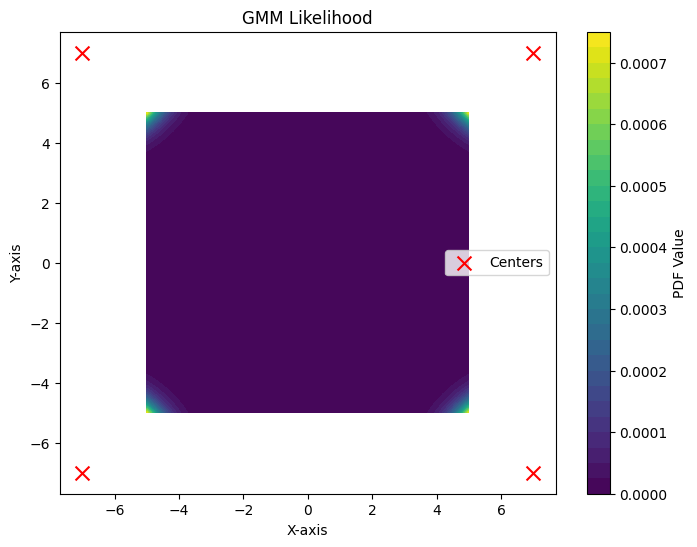

GMM PDF at [1.  1.5] => 0.00000
Batch likelihoods: tensor([1.6359e-16, 5.5258e-13, 4.9103e-06])


In [101]:
# 1) 모델 초기화 (기존 pickle이 없으면 새로 생성, 있으면 로드)
model = GMMModel(
    weights=weights,
    means=means,
    covariance=covariances,
    model_path=model_path,
    random_state=42
)

# 2) 텐서 입력에 대한 likelihood 계산
x_sample = torch.tensor([1.0, 1.5])        # (2,) shape
likelihood = model(x_sample)  # 모델 호출
print(f"GMM PDF at {x_sample.numpy()} => {likelihood.item():.5f}")

# 3) 여러 샘플(batch) 입력
x_batch = torch.tensor([[1.0, 1.5],
                        [2.0, 2.0],
                        [4.0, 4.0]], dtype=torch.float32)
likelihoods = model(x_batch)
print("Batch likelihoods:", likelihoods)